Preprocessing 

In [2]:
import Oracle_Assignment_2
import numpy as np 
import matplotlib.pyplot as plt
train_data,test_data = Oracle_Assignment_2.q1_get_cifar100_train_test(23627)
train_features,train_labels = [],[]
test_features,test_labels = [],[]
for x in train_data:
    train_features.append(x[0])
    train_labels.append(x[1])
train_features = np.array(train_features)
train_labels = np.array(train_labels) # -1 and 1 
for x in test_data:
    test_features.append(x[0])
    test_labels.append(x[1])
test_features = np.array(test_features)
test_labels = np.array(test_labels)
train_mean = np.mean(train_features, axis=0)  # modified shape (27,)
train_std = np.std(train_features, axis=0)    # modified shape (27,)
# print(train_features.shape,train_labels.shape) # Returns : (1000,27) (1000,)
# print(test_features.shape,test_labels.shape) # Returns : (200,27) (200,)

Task : Run the perceptron algorithm on your data. Report whether it converges, or appears
not to. If it doesn’t seem to converge, make certain that you are reasonably sure.

Question : A plot between misclassification rate and number of iterations for the perceptron algorithm as defined
in Task 1.

Did not converge


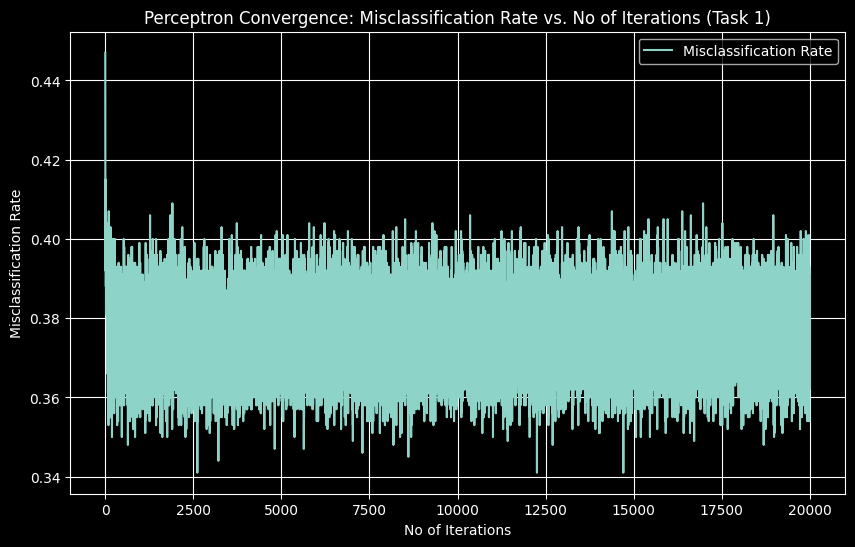

In [3]:
def Perceptron(train_features,train_labels,max_iterations = 20000):
    d = len(train_features[0])
    w = [0.0 for i in range(d)]
    b = 0.0
    misclassification_rates = []
    converged = False
    for t in range(max_iterations):
        misclassified = 0
        for i in range(len(train_features)):
            x = train_features[i]
            y = train_labels[i]
            dot_product = sum([w[j]*x[j] for j in range(d)]) # calculating wT.x
            predicted_label = dot_product + b 
            if predicted_label*y <= 0:
                misclassified += 1
                for j in range(d):
                    w[j] += y*x[j]
                b += y
        misclassification_rate = misclassified/len(train_features)
        misclassification_rates.append(misclassification_rate)
        if misclassified == 0:
            converged = True
            print(f"Converged after {t+1} iterations")
            break
    else:
        print("Did not converge")
    return w,b,misclassification_rates,converged 
w,b,misclassification_rates,converged = Perceptron(train_features,train_labels)
iterations = list(range(1, len(misclassification_rates) + 1))
plt.figure(figsize=(10, 6))
plt.plot(iterations, misclassification_rates, label="Misclassification Rate")
plt.xlabel("No of Iterations")
plt.ylabel("Misclassification Rate")
plt.title("Perceptron Convergence: Misclassification Rate vs. No of Iterations (Task 1)")
plt.grid(True)
plt.legend()
plt.show()

Task : Linear SVM; Construct a slack support vector machine with the linear kernel. Solve both the primal
and dual versions of the SVM quadratic programs using cvxopt. Use the SVM’s solution to isolate
the sources of non-separability

Question-1: Which, between the primal and dual, is solved faster for Task 2. Report the times taken for running
both, and justify any patterns you see.

Question-2 : Give the indicies which are causing inseparability in the data in a csv file of name inseperable_{sr_number}.csv

Primal SVM :
- The primal SVM is solved using the cvxopt library.    
- Returns w,b,xi(slack variables) and time_taken 

Dual SVM :
- The dual SVM is solved using the cvxopt library.
- Returns w,b,alphas (Lagrange Multipliers for inequality constraints) and time_taken

In [28]:
import numpy as np 
import cvxopt 
import time 

class SVM:
    def __init__(self, regularization_parameter=1.0):
        self.C = regularization_parameter  # Regularization parameter (tradeoff between maximizing margin and minimizing slack)
        self.w_primal = None
        self.b_primal = None
        self.slack_values = None
        self.alpha_dual = None
        self.w_dual = None
        self.b_dual = None
        self.primal_time = None
        self.dual_time = None
    def Primal_SVM(self,X,y):
        num_samples, num_features = len(X), len(X[0])
        variable_size = num_features + 1 + num_samples
        P = np.zeros((variable_size, variable_size))
        for i in range(num_features): # For ||w||^2 term
            P[i, i] = 1
        q = np.zeros(variable_size)
        q[num_features + 1:] = self.C * np.ones(num_samples) # For slack variables
        # Inequality constraints G and h 
        G = np.zeros((2*num_samples, variable_size))
        h = np.zeros(2*num_samples)
        # Constraint 1: y_i (w^T x_i + b) >= 1 - ξ_i
        for i in range(num_samples):
            G[i, :num_features] = -y[i] * X[i]
            G[i, num_features] = -y[i]
            G[i, num_features + 1 + i] = -1
            h[i] = -1
        # Constraint 2: ξ_i >= 0
        for i in range(num_samples):
            G[num_samples + i, num_features + 1 + i] = -1
            h[num_samples + i] = 0
        # Convert to cvxopt format
        P = cvxopt.matrix(P)
        q = cvxopt.matrix(q)
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        # Solve the QP problem and Measure time taken to solve the primal SVM
        cvxopt.solvers.options['show_progress'] = False
        start_time = time.time()
        solution = cvxopt.solvers.qp(P, q, G, h)
        self.primal_time = time.time() - start_time
        # Extract solution
        primal_solution = np.array(solution['x']).flatten()
        self.w_primal = primal_solution[:num_features]
        self.b_primal = primal_solution[num_features]
        self.slack_values = primal_solution[num_features + 1:]

        # Identify non-separable points (ξ_i > 1)
        non_separable_indices = np.where(self.slack_values > 1)[0] # ξ_i > 1 which implies y_i (w^T x_i + b) < 0
        return self.w_primal, self.b_primal, self.slack_values, non_separable_indices
    def Dual_SVM(self,X,y):
        num_samples, num_features = len(X), len(X[0])

        # Compute the kernel matrix (linear kernel: K[i,j] = x_i^T x_j)
        K = np.dot(X, X.T)
        P = np.outer(y, y) * K
        q = -np.ones(num_samples)
        # Box constraints: 0 < alpha_i < C
        G = np.vstack((-np.eye(num_samples), np.eye(num_samples)))
        h = np.hstack((np.zeros(num_samples), self.C * np.ones(num_samples)))
        # Equality constraint: A and b
        A = y.reshape(1, -1)
        b = 0.0

        # Convert to cvxopt format
        P = cvxopt.matrix(P)
        q = cvxopt.matrix(q)
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        A = cvxopt.matrix(A, (1, num_samples), 'd')
        b = cvxopt.matrix(b)

        # Solve the QP problem and measure time
        cvxopt.solvers.options['show_progress'] = False
        start_time = time.time()
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.dual_time = time.time() - start_time

        # Extract dual variables (alpha_i)
        self.alpha_dual = np.array(solution['x']).flatten()

        # Compute w and b
        self.w_dual = np.sum((self.alpha_dual * y).reshape(-1, 1) * X, axis=0)
        support_vector_indices = (self.alpha_dual > 1e-5) & (self.alpha_dual < self.C - 1e-5)
        if np.any(support_vector_indices):
            self.b_dual = np.mean(y[support_vector_indices] - np.dot(X[support_vector_indices], self.w_dual))
        else:
            self.b_dual = 0

        # Identify misclassified (non-separable) points
        predictions = np.sign(np.dot(X, self.w_dual) + self.b_dual)
        non_separable_indices = np.where(predictions * y < 0)[0] # y_i (w^T x_i + b) < 0
        return self.w_dual, self.b_dual, self.alpha_dual, non_separable_indices
    def Compare_solutions(self):
        print(f"Primal SVM Time: {self.primal_time:.4f} seconds")
        print(f"Dual SVM Time: {self.dual_time:.4f} seconds")
        w_diff = np.linalg.norm(self.w_primal - self.w_dual)
        b_diff = abs(self.b_primal - self.b_dual)
        print(f"Difference in w (L2 norm): {w_diff:.4f}")
        print(f"Difference in b: {b_diff:.4f}")
    def save_non_seperable_indices(self,indices,sr_number):
        file_name = f"inseparable_{sr_number}.csv"
        np.savetxt(file_name,indices,delimiter=",",fmt = "%d")
        print(f"Indices of non-separable points saved to {file_name}")
    
svm = SVM(regularization_parameter=1.0)
w_primal, b_primal, slack_values, primal_non_separable_indices = svm.Primal_SVM(train_features, train_labels)
w_dual, b_dual, alpha_dual, dual_non_separable_indices = svm.Dual_SVM(train_features, train_labels)
print("Primal SVM Results:")
print(f"Number of points with ξ_i > 1: {len(primal_non_separable_indices)}")
print(f"Indices of non-separable points (primal): {primal_non_separable_indices}")
print("\nDual SVM Results:")
print(f"Number of misclassified points: {len(dual_non_separable_indices)}")
print(f"Indices of non-separable points (dual): {dual_non_separable_indices}")
svm.Compare_solutions()
svm.save_non_seperable_indices(primal_non_separable_indices,23627)

Primal SVM Results:
Number of points with ξ_i > 1: 281
Indices of non-separable points (primal): [  0   1   5   8  12  20  23  24  25  26  27  28  30  35  37  39  40  42
  44  45  51  52  56  78  82  86  87  89  94  95  96  98  99 102 106 108
 110 112 115 116 118 123 128 134 143 150 151 152 153 154 156 159 165 169
 174 183 188 190 191 195 207 209 213 217 220 221 225 227 230 237 246 251
 253 257 259 260 262 265 267 271 278 284 285 286 288 297 300 304 312 314
 316 317 323 328 336 338 345 355 358 359 360 363 372 375 380 384 388 395
 397 398 402 404 410 416 419 421 428 431 432 435 436 438 440 441 443 449
 450 451 454 455 456 457 465 468 470 475 485 487 489 493 495 499 506 509
 516 517 521 526 530 533 537 541 547 551 554 558 560 565 566 567 570 573
 577 580 586 588 596 602 604 605 607 608 611 612 613 617 620 636 639 648
 650 660 661 663 666 667 671 674 675 677 679 681 682 683 685 686 693 694
 696 697 699 700 705 709 710 714 721 723 726 727 729 730 732 735 751 752
 757 758 761 769 770 771 77

Task : Kernelized SVM; Repeat the previous construction, but with the Gaussian kernel this time. Choose
your hyperparameters such that non-separability is no longer an issue, and your decision boundary is
consistent with the training data’s labels.

Question : The final misclassification rate for the kernelized SVM for Task 3.

In [ ]:
import numpy as np
import cvxopt 
import time
class Gaussian_Kernel_SVM:
    def __init__(self,regularization_parameter,gamma):
        self.C = regularization_parameter
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.support_labels = None
        self.support_alpha = None
        self.w = None
        self.b = None
        self.time_taken = None
    def Gaussian_kernel(self,x1,x2):
        squared_distance = np.sum((x1 - x2) ** 2)
        return np.exp(-self.gamma * squared_distance)
    def Kernel_matrix(self,X):
        num_samples = len(X)
        K = np.zeros((num_samples, num_samples))
        for i in range(num_samples):
            for j in range(num_samples):
                K[i, j] = self.gaussian_kernel(X[i], X[j])
        return K
    def Dual_SVM(self,X,y):
        num_samples, num_features = len(X), len(X[0])

        # Compute the kernel matrix (linear kernel: K[i,j] = x_i^T x_j)
        K = np.dot(X, X.T)
        P = np.outer(y, y) * K
        q = -np.ones(num_samples)
        # Box constraints: 0 < alpha_i < C
        G = np.vstack((-np.eye(num_samples), np.eye(num_samples)))
        h = np.hstack((np.zeros(num_samples), self.C * np.ones(num_samples)))
        # Equality constraint: A and b
        A = y.reshape(1, -1)
        b = 0.0

        # Convert to cvxopt format
        P = cvxopt.matrix(P)
        q = cvxopt.matrix(q)
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        A = cvxopt.matrix(A, (1, num_samples), 'd')
        b = cvxopt.matrix(b)

        # Solve the QP problem and measure time
        cvxopt.solvers.options['show_progress'] = False
        start_time = time.time()
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.time_taken = time.time() - start_time

        # Extract alpha values
        self.alpha = np.array(solution['x']).flatten()

        # Identify support vectors
        range_alpha = (self.alpha > 1e-5) & (self.alpha < self.C - 1e-5)
        self.support_vectors = X[range_alpha]
        self.support_labels = y[range_alpha]
        self.support_alpha = self.alpha[range_alpha]
        support_vector_indices = np.where(range_alpha)[0]
        # Compute b using support vectors
        if len(self.support_vectors) > 0:
            b_sum = 0
            for i in range(len(self.support_vectors)):
                kernel_sum = 0
                for j in range(len(self.support_vectors)):
                    kernel_sum += self.support_alpha[j] * self.support_labels[j] * \
                                  self.Gaussian_kernel(self.support_vectors[i], self.support_vectors[j])
                b_sum += self.support_labels[i] - kernel_sum
            self.b = b_sum / len(self.support_vectors)
        else:
            self.b = 0
        self.w = np.sum((self.alpha * y).reshape(-1, 1) * X, axis=0)
        predictions = np.sign(np.dot(X, self.w) + self.b)
        non_separable_indices = np.where(predictions * y < 0)[0]
        return self.alpha, support_vector_indices, non_separable_indices
    def Predict(self,X):
        num_test_samples = len(X)
        predictions = np.zeros(num_test_samples)
        for i in range(num_test_samples):
            decision_value = 0 # f(x) = Σ α_i y_i K(x_i, x) + b
            for j in range(len(self.support_vectors)):
                decision_value += self.support_alpha[j] * self.support_labels[j] * \
                                  self.Gaussian_kernel(self.support_vectors[j], X[i])
            predictions[i] = np.sign(decision_value + self.b)
        return predictions     
    def misclassification_rate(self,X,y):
        predictions = self.Predict(X)
        misclassified = np.sum(predictions != y)
        return misclassified / len(y)
# TODO : Chooseyour hyperparameters such that non-separability is no longer an issue, and your decision boundary is consistent with the training data’s labels.
svm = Gaussian_Kernel_SVM(regularization_parameter=100000.0, gamma=99999)
alpha_values, support_vector_indices, dual_non_separable_indices = svm.Dual_SVM(train_features, train_labels)
print(f"Training time: {svm.time_taken:.4f} seconds")
print(f"Number of support vectors: {len(support_vector_indices)}")
print(f"Number of points causing non_seperability: {len(dual_non_separable_indices)}")
# Compute and report the misclassification rate
misclassification_rate = svm.misclassification_rate(train_features, train_labels)
print(f"Final misclassification rate on training data: {misclassification_rate:.4f}")
misclassification_rate_test = svm.misclassification_rate(test_features, test_labels)
print(f"Final misclassification rate on test data: {misclassification_rate_test:.4f}")

Training time: 2.0292 seconds
Number of support vectors: 1000
Number of points causing non_seperability: 273
Final misclassification rate on training data: 0.0000
Final misclassification rate on test data: 0.5000


Task : Perceptron, again; Retrain the perceptron, after removing the sources of non-separability isolated
by the linear SVM. Verify that it converges

Question : A plot between misclassification rate and iterations for the perceptron for Task 4.

Points to remove: 281 (Expected: ?)
Modified dataset: 719 points
Converged after 296 iterations
Perceptron converged
Final misclassification rate: 0.0000


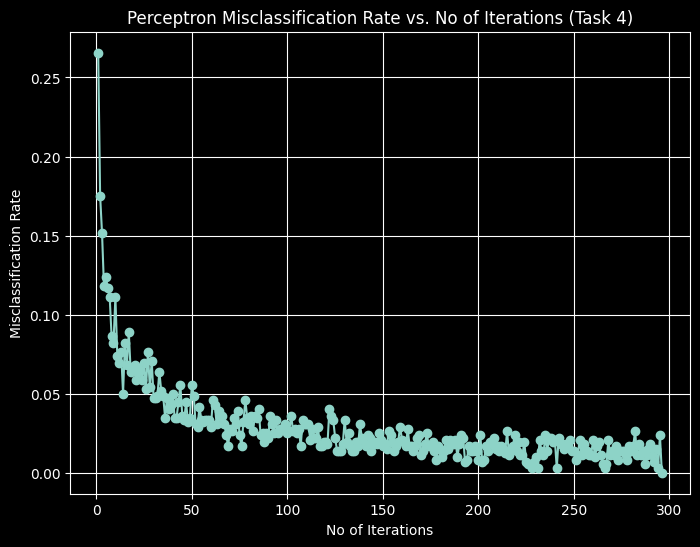

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def Task_4(X, y, C=1.0):
    # Identify the points causing inseparability using the primal solution
    w_primal, b_primal, slack_values, primal_non_separable_indices = svm.Primal_SVM(X, y)
    points_to_remove = X[primal_non_separable_indices]
    print(f"Points to remove: {len(points_to_remove)} (Expected: ?)")
    mask = np.ones(len(X), dtype=bool)
    mask[primal_non_separable_indices] = False
    X_modified, y_modified = X[mask], y[mask]
    print(f"Modified dataset: {len(X_modified)} points")
    w, b, misclassification_rates, converged = Perceptron(X_modified, y_modified)
    if converged:
        print("Perceptron converged")
    else:
        print("Perceptron did not converge within max_iterations")
    print(f"Final misclassification rate: {misclassification_rates[-1]:.4f}")
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(misclassification_rates) + 1), misclassification_rates, marker='o', linestyle='-')
    plt.xlabel('No of Iterations')
    plt.ylabel('Misclassification Rate')
    plt.title('Perceptron Misclassification Rate vs. No of Iterations (Task 4)')
    plt.grid(True)
    plt.show()

X, y = train_features, train_labels
Task_4(X, y, C=1.0)